# **Objectron: 3D Object Detection Dataset**

Google research dataset team just added a new state of art 3-D video dataset for object detection i.e. Objectron, which was published with a C-UDA(Computational Use of Data Agreement) license, this dataset contains short object-centric video clips capturing objects from different angles, each of which is provided with an AR(augmented reality) session metadata(extra information about data) that includes camera angles, poses, sparse point-cloud, and surface planes.

To read about it more, please refer [this](https://analyticsindiamag.com/objectron-dataset-tutorial-in-python/) article.

## **Code Implementation**

## clone repo

In [2]:
!git clone https://github.com/google-research-datasets/Objectron.git

Cloning into 'Objectron'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (139/139), done.
remote: Total 190 (delta 87), reused 135 (delta 46), pack-reused 0
Receiving objects: 100% (190/190), 39.44 MiB | 35.18 MiB/s, done.
Resolving deltas: 100% (87/87), done.


## Downloading Objectron Dataset
The dataset is stored in the objectron bucket on Google Cloud storage, and include the following attributes:

* Video sequences (gs://objectron/videos/class/batch-i/j/video.MOV)

* Annotations labels(gs://objectron/videos/class/batch-i/j/video.MOV)
* Metadata
* Processed dataset(tf.records)
* Index of all available samples.

Public API to access the annotations and videos are available, for example:
* annotations: https://storage.googleapis.com/objectron/annotations/class/batch-i/j.pbdata
* videos: https://storage.googleapis.com/objectron/videos/class/batch-i/j/video.MOV


## 1.Downloading Data using gsutil

`gsutil` is the small utility to execute shell commands like ls and cp on the google storage bucket. 
For example you can **use**

In [3]:
!gsutil ls gs://objectron/v1/records_shuffled

gs://objectron/v1/records_shuffled/bike_$folder$
gs://objectron/v1/records_shuffled/book_$folder$
gs://objectron/v1/records_shuffled/bottle_$folder$
gs://objectron/v1/records_shuffled/camera_$folder$
gs://objectron/v1/records_shuffled/cereal_box_$folder$
gs://objectron/v1/records_shuffled/chair_$folder$
gs://objectron/v1/records_shuffled/cup_$folder$
gs://objectron/v1/records_shuffled/laptop_$folder$
gs://objectron/v1/records_shuffled/shoe_$folder$
gs://objectron/v1/records_shuffled/bike/
gs://objectron/v1/records_shuffled/book/
gs://objectron/v1/records_shuffled/bottle/
gs://objectron/v1/records_shuffled/camera/
gs://objectron/v1/records_shuffled/cereal_box/
gs://objectron/v1/records_shuffled/chair/
gs://objectron/v1/records_shuffled/cup/
gs://objectron/v1/records_shuffled/laptop/
gs://objectron/v1/records_shuffled/shoe/


## 2.Downloading Data using Public HTTP API
The users can download data without authentication directly using HTTP address. The dataset's public URL is `https://storage.googleapis.com/objectron`. You can use curl, request or any other downloader for this purpose.


In [4]:
import requests
public_url = "https://storage.googleapis.com/objectron"
blob_path = public_url + "/v1/index/cup_annotations_test"
video_ids = requests.get(blob_path).text
video_ids = video_ids.split('\n')
# Download the first ten videos in cup test dataset
for i in range(1):
    video_filename = public_url + "/videos/" + video_ids[i] + "/video.MOV"
    metadata_filename = public_url + "/videos/" + video_ids[i] + "/geometry.pbdata"
    annotation_filename = public_url + "/annotations/" + video_ids[i] + ".pbdata"
    # video.content contains the video file.
    video = requests.get(video_filename)
    metadata = requests.get(metadata_filename)
    annotation = requests.get(annotation_filename)
    file = open("example.MOV", "wb")
    file.write(video.content)
    file.close()

### play video

In [5]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('example.MOV','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

# Parsing Objectron's SequenceExamples
This tutorial shows how to use the Objectron SequenceExamples. Unlike our normal tf.examples where each example holds a single image frame with annotation, SequenceExamples hold the entire video sequence and corresponding annotation in them. These files are useful for training video models, multi-view models, as well as tracking objects in 3D across multiple frames


In [6]:
%cd Objectron

/content/Objectron


In [7]:
%cd objectron

/content/Objectron/objectron


In [8]:
!pip install frozendict

In [9]:
objectron_buckett = 'gs://objectron'
# Importing the necessary modules. We will run this notebook locally.

import tensorflow as tf
import glob
from IPython.core.display import display,HTML
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from objectron.schema import features
from objectron.dataset import box
from objectron.dataset import graphics

Every sequence example has two parts: context and feature lists. The context are sequence attributes which apply to the entire sequence. In our SequenceExamples, context contains two items: 1) `count`, the number of frames in the sequence, and 2) `sequence_id`, a string field in the format of `class/batch-i/j`. 

The sequence features contains the list of the features in the sequence. They are very similar as the tf.examples used in the Hello World notebook. Except each field is a list of the size `count` of that feature. The feature_lists contain a key, value map where each key is associated with a repeated set of Features (a FeatureList).
See `objectron/schema/features.py` for more information.

See [`parse_single_sequence_example API`](https://www.tensorflow.org/api_docs/python/tf/io/parse_single_sequence_example) for more details.

In our dataset, sequence examples are located in `/objectron/v1/sequences/class/class_test*` and `class_train*`, where the class in one of the object categories. (`bike, book, bottle, camera, cereal_box, chair, cup, laptop, shoe`). Keep in mind each sequence example corresponds to a single video file, so the iterator over the entire dataset will produce total number of videos in the dataset (about 2000 video per class) before repeating the data. So make sure the your data pipelines include `.repeat()`. 

In [10]:
# Data pipeline for parsing the sequence examples. In this example, we grab a few frames from each sequence.

NUM_KEYPOINTS = 9
NUM_FRAMES = 4

def parse_tfrecord(example):
    context, data = tf.io.parse_single_sequence_example(
                            example, 
                            sequence_features = features.SEQUENCE_FEATURE_MAP,
                            context_features = features.SEQUENCE_CONTEXT_MAP
                        )
    
    # Number of frames in this video sequence
    num_examples = context['count']
    # The unique sequence id (class/batch-i/j) useful for visualization/debugging
    video_id = context['sequence_id']
    
    rand = tf.random.uniform([NUM_FRAMES], 0, num_examples, tf.int64)
    data['frame_ids'] = rand
    # Grab 4 random frames from the sequence and decode them
    for i in range(NUM_FRAMES):
        id = rand[i]
        image_tag = 'image-{}'.format(i)
        data[image_tag] = data[features.FEATURE_NAMES['IMAGE_ENCODED']][id]
        data[image_tag] = tf.image.decode_png(data[image_tag], channels=3)
        data[image_tag].set_shape([640, 480, 3])
    return context, data

shards = tf.io.gfile.glob(objectron_buckett + '/v1/sequences/book/book_test*')

dataset = tf.data.TFRecordDataset(shards)
dataset = dataset.map(parse_tfrecord)



In [11]:
num_rows = 10
for context, data in dataset.take(num_rows):
    fig, ax = plt.subplots(1, NUM_FRAMES, figsize = (12, 16))
    
    for i in range(NUM_FRAMES):
        num_frames = context['count']
        id = data['frame_ids'][i]
        image = data['image-{}'.format(i)].numpy()
        num_instances = data[features.FEATURE_NAMES['INSTANCE_NUM']][id].numpy()[0]
        keypoints = data[features.FEATURE_NAMES['POINT_2D']].values.numpy().reshape(num_frames, num_instances, NUM_KEYPOINTS, 3)
        for instance_id in range(num_instances):
            image = graphics.draw_annotation_on_image(image, keypoints[id, instance_id, :, :], [9])
        ax[i].grid(False)
        ax[i].imshow(image);
        ax[i].get_xaxis().set_visible(False)
        ax[i].get_yaxis().set_visible(False)
        
    fig.tight_layout();
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Objectron Tutorial: Grabbing samples from shareded TF.record files.

This notebook provide an example on how to grab a few rows from the sharded tf.record files. We will be using the `tf.data.TFRecordDataset` for reading the datasets. For more information checkout [TFRecord and tf.train.Example](https://www.tensorflow.org/tutorials/load_data/tfrecord#reading_a_tfrecord_file).

In [12]:
objectron_buckett = 'gs://objectron/v1/records_shuffled'
NUM_PARALLEL_CALLS = 4
WIDTH = 480
HEIGHT = 640
NUM_CHANNELS = 3
# The 3D bounding box has 9 vertices, 0: is the center, and the 8 vertices of the 3D box.
NUM_KEYPOINTS = 9
BATCH_SIZE = 4

In [13]:
import glob
from IPython.core.display import display,HTML
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from objectron.schema import features
from objectron.dataset import box
from objectron.dataset import graphics

In [14]:
def parse(example):
  """Parses a single tf.Example and decode the `png` string to an array."""
  data = tf.io.parse_single_example(example, features = features.FEATURE_MAP)
  data['image'] = tf.image.decode_png(data[features.FEATURE_NAMES['IMAGE_ENCODED']], channels=NUM_CHANNELS)
  data['image'].set_shape([HEIGHT, WIDTH, NUM_CHANNELS])
  return data 

def augment(data):
  return data

def normalize(data):
  """Convert `image` from [0, 255] -> [-1., 1.] floats."""
  data['image'] = tf.cast(data['image'], tf.float32) * (2. / 255.) - 1.0  
  return data

def load_tf_record(input_record):
  dataset = tf.data.TFRecordDataset(input_record)

  dataset = dataset.map(parse, num_parallel_calls = NUM_PARALLEL_CALLS)\
                   .map(augment, num_parallel_calls = NUM_PARALLEL_CALLS)\
                   .map(normalize, num_parallel_calls = NUM_PARALLEL_CALLS)
  # Our TF.records are shuffled in advance. If you re-generate the dataset from the video files, you'll need to
  # shuffle your examples. Keep in mind that you cannot shuffle the entire datasets using dataset.shuffle, since 
  # it will be very slow.
  dataset = dataset.shuffle(100)\
                   .repeat()\
                   .batch(BATCH_SIZE)\
                   .prefetch(buffer_size=10)
  return dataset

training_shards   = tf.io.gfile.glob(objectron_buckett + '/chair/chair_train*')
dataset = load_tf_record(training_shards)

In [15]:
num_rows = 10
for data in dataset.take(num_rows):
  fig, ax = plt.subplots(1, BATCH_SIZE, figsize = (12, 16))
  # number_objects_batch is a tensor of shape (batch-size,) which tells the 
  # number of objects in each batch slice.
  number_objects_batch = data[features.FEATURE_NAMES['INSTANCE_NUM']]
  num_obj_cumsum = np.sum(number_objects_batch)
  image_width = data[features.FEATURE_NAMES['IMAGE_WIDTH']]
  image_height = data[features.FEATURE_NAMES['IMAGE_HEIGHT']]
  # For debugging, Get the sample index from the IMAGE_FILENAME field.
  # print(data[features.FEATURE_NAMES['IMAGE_FILENAME']])
  keypoints = data[features.FEATURE_NAMES['POINT_2D']].values.numpy().reshape(np.sum(number_objects_batch), NUM_KEYPOINTS, 3)
  # The object annotation is a list of 3x1 keypoints for all the annotated
  # objects. The objects can have a varying number of keypoints. First we split
  # the list according to the number of keypoints for each object. This
  # also leaves an empty array at the end of the list.
  batch_keypoints = np.split(keypoints, np.array(np.cumsum(number_objects_batch)))
  # Visualize the first image/keypoint pair in the batch
  for id in range(BATCH_SIZE):
    w = image_width.numpy()[id][0]
    h = image_height.numpy()[id][0]
    # DeNormalize the image (for visualization purpose only)
    image = tf.cast((data['image'] + 1.0) / 2.0 * 255, tf.uint8).numpy()[id]
    num_instances = number_objects_batch[id].numpy()[0]
    keypoints_per_sample = batch_keypoints[id]
    for instance_id in range(num_instances):
      image = graphics.draw_annotation_on_image(image, keypoints_per_sample[instance_id, :, :], [9])
      
    ax[id].grid(False)
    ax[id].imshow(image);

  fig.tight_layout();
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

### More Notebooks at: https://github.com/google-research-datasets/Objectron/notebooks

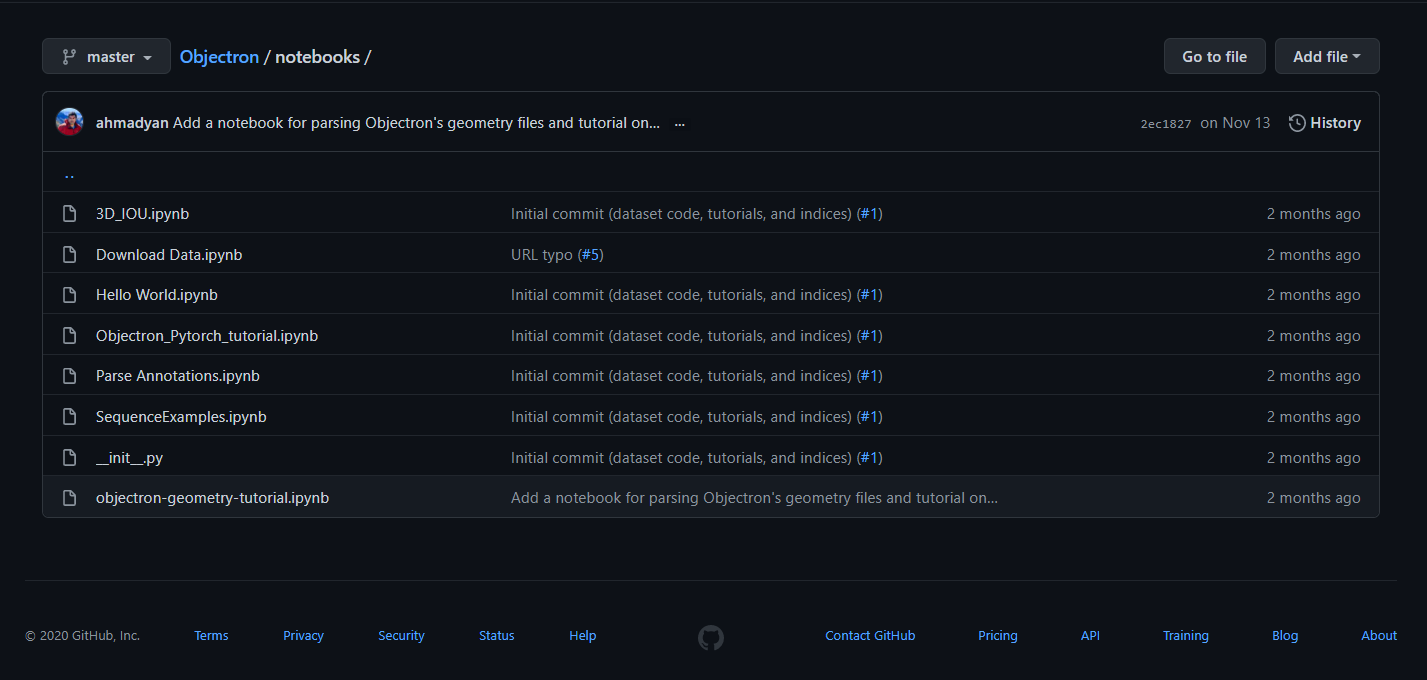

#**Related Articles:**

> * [Guide to Google's Objectron](https://analyticsindiamag.com/objectron-dataset-tutorial-in-python/)

> * [Guide to OpenAI's CLIP](https://analyticsindiamag.com/hands-on-guide-to-openais-clip-connecting-text-to-images/)

> * [Guide to VISSL](https://analyticsindiamag.com/guide-to-vissl-vision-library-for-self-supervised-learning/)

> * [Unet Image Segmentation Model](https://analyticsindiamag.com/my-experiment-with-unet-building-an-image-segmentation-model/)

> * [Comparison of Semantic, Instance and Panoptic Segmentation](https://analyticsindiamag.com/semantic-vs-instance-vs-panoptic-which-image-segmentation-technique-to-choose/)

> * [Panoptic Segmentation](https://analyticsindiamag.com/guide-to-panoptic-segmentation-a-semantic-instance-segmentation-approach/)

> * [PaddleSeg](https://analyticsindiamag.com/guide-to-asymmetric-non-local-neural-networks-using-paddleseg/)